# Importação das Bibliotecas

In [87]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Funções Auxiliares

In [88]:
def display_image(image, title = "", size = 5):
    width, height = image.shape[0], image.shape[1]
    aspect_ratio = width/height
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Função de pré-processamento apenas extrair o objeto principal binarizado.

In [ ]:
def get_main_object(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    borders = cv2.Canny(blur, 30, 150)
    
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(borders, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour_obj = contours[0]

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour_obj], -1, 255, -1)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closing

# Funções Principais

Função principal, obtém a imagem binarizada contendo apenas o objeto de interesse e o seu respectivo contorno.

Retorna a **imagem alinhada** na horizontal, **ângulo de correção**, modelo **PCA** ajustado e o **centróide** do objeto principal

In [90]:
def pca_image_alignment(binary_image):

    y_coords, x_coords = np.where(binary_image == 255)
    pts = np.column_stack((x_coords, y_coords))

    pca = PCA(n_components=2)
    pca.fit(pts)

    principal_component = pca.components_[0]
    angle_rad = np.arctan2(principal_component[1], principal_component[0])
    angle = np.degrees(angle_rad)

    if abs(angle) > 90:
        angle = angle - 180 if angle > 0 else angle + 180

    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))
    centroid = (cx, cy)

    (h, w) = binary_image.shape[:2]

    alignment_matrix = cv2.getRotationMatrix2D(centroid, angle, 1.0)
    aligned_image = cv2.warpAffine(binary_image, alignment_matrix, (w, h))

    return aligned_image, angle, pca, centroid

Função opcional apenas pra visualização das componentes principais encontradas pelo modelo PCA.

Recebe a imagem binarizada e as informações necessárias para correção como o ângulo detectado desta imagem a ser corrigido, modelo PCA ajustado e o centróide.

Retorna a preview da imagem a ser corrigida com marcações e informações.

In [91]:
def pca_image_preview(binary_image, angle, pca, centroid):
    image_preview = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    cx, cy = centroid
    variancias = pca.explained_variance_ratio_

    linha = min(binary_image.shape) // 3
    tam_linha1 = linha * variancias[0]
    tam_linha2 = linha * variancias[1]

    angle_rad = angle * np.pi / 180

    end_point1 = (
        int(cx + tam_linha1 * np.cos(angle_rad)),
        int(cy + tam_linha1 * np.sin(angle_rad))
    )
    cv2.arrowedLine(image_preview, centroid, end_point1, (0, 0, 255), 5)

    end_point2 = (
        int(cx + tam_linha2 * np.cos(angle_rad + np.pi/2)),
        int(cy + tam_linha2 * np.sin(angle_rad + np.pi/2))
    )
    cv2.arrowedLine(image_preview, centroid, end_point2, (255, 0, 0), 5)

    font_scale = max(1, min(binary_image.shape) / 500)
    thickness = max(1, int(font_scale * 2))
    text = f"Angulo: {angle:.2f} graus"
    
    (_, text_height), _ = cv2.getTextSize(
        text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
    )
    
    margin = 20
    
    text_x = margin
    text_y = int(text_height + margin)
    
    cv2.putText(
        image_preview,
        text,
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (255, 0, 0),
        thickness
    )
    
    return image_preview

# Exemplo de Alinhamento de Imagem com PCA

Carrega-se uma imagem qualquer, gera-se a imagem binarizada obtendo-se apenas o objeto principal.

In [92]:
image = cv2.imread("../../../../imgs/private/1b.jpg")
object = get_main_object(image)

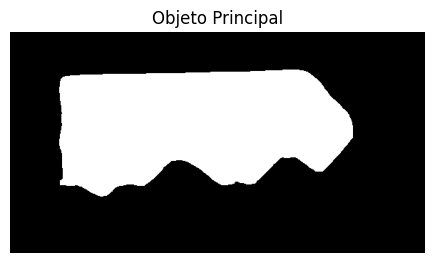

In [93]:
display_image(object, "Objeto Principal", 10)

In [ ]:
aligned_image, angle, pca, centroid = pca_image_alignment(object)
misaligned_pca_preview = pca_image_preview(object, angle, pca, centroid)

In [97]:
_, angle, pca, centroid = pca_image_alignment(aligned_image)
aligned_pca_preview = pca_image_preview(aligned_image, angle, pca, centroid)

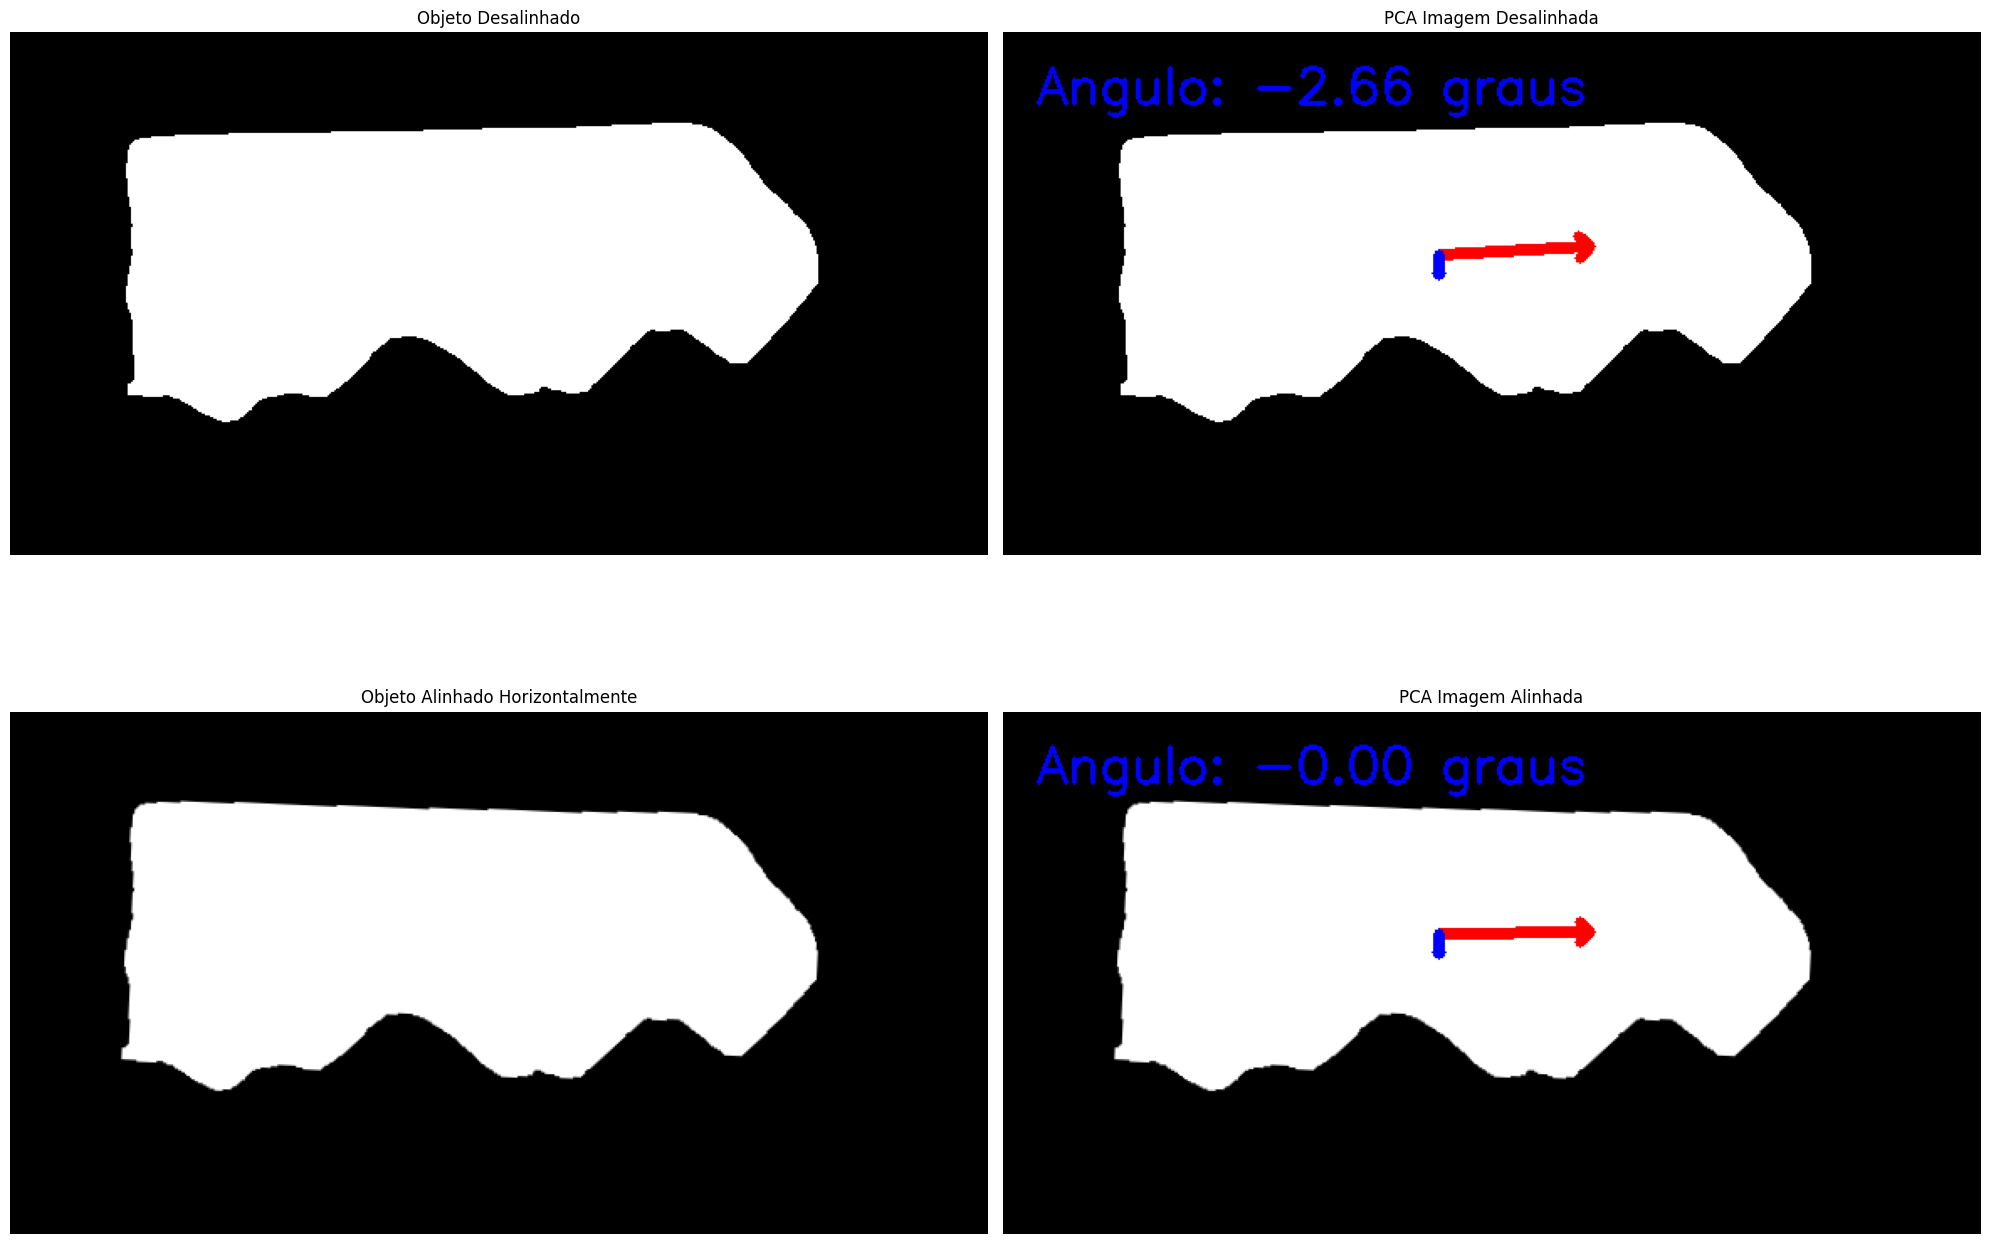

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes[0, 0].imshow(object, cmap='gray')
axes[0, 0].set_title("Objeto Desalinhado")
axes[0, 0].axis("off")
axes[0, 1].imshow(cv2.cvtColor(misaligned_pca_preview, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("PCA Imagem Desalinhada")
axes[0, 1].axis("off")

axes[1, 0].imshow(aligned_image, cmap='gray')
axes[1, 0].set_title("Objeto Alinhado Horizontalmente")
axes[1, 0].axis("off")
axes[1, 1].imshow(cv2.cvtColor(aligned_pca_preview, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("PCA Imagem Alinhada")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# Referências

[Automatic Image Alignment Using Principal Component Analysis](https://ieeexplore.ieee.org/document/8540825)

[Detecting Orientation of Objects in Image using PCA and OpenCV](https://analyticsindiamag.com/ai-trends/detecting-orientation-of-objects-in-image-using-pca-and-opencv/)

[Aligning images using PCA](https://www.kaggle.com/code/darkrubiks/aligning-images-using-pca)